In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os
import re
import collections  # returns frequencies 

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Pull data coming in Funding Projects KS 
ks_proj2016 = pd.read_csv('ks-projects-201612.csv', encoding = "ISO-8859-1")
ks_proj2018 = pd.read_csv('ks-projects-201801.csv')
ks_proj2016.shape
ks_proj2018.shape
ks_proj2016.head()

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
# stripe out lead and trailing spaces from columns 
xcols = [x.strip() for x in ks_proj2016.columns]
ks_proj2016.columns = xcols
ks_proj2016.columns
ks_proj2016.dtypes

In [ ]:
# Formating: convert goal, pledged, backers, and usd pledged to numbers 
ks_proj2016['goal'] = pd.to_numeric(ks_proj2016.goal, errors='coerce')
ks_proj2016['pledged'] = pd.to_numeric(ks_proj2016.pledged, errors='coerce')
ks_proj2016['usd pledged'] = pd.to_numeric(ks_proj2016['usd pledged'], errors='coerce')
ks_proj2016['backers'] = pd.to_numeric(ks_proj2016.backers, errors='coerce')
ks_proj2016[['goal','pledged','usd pledged','backers']].dtypes

In [ ]:
# Columns "Unnamed 13" ... "Unnamed: 16" are due to data processing issue
    # Multiple rows where name mistakenly expanded out.  
len(ks_proj2016[ks_proj2016["Unnamed: 13"].notnull()])   # 625 / 320k rows affected. For simplicity will remove these rows.
ks_proj2016 = ks_proj2016[ks_proj2016["Unnamed: 13"].isnull()] # remove rows with extraneous values 
ks_proj2016.iloc[1450:1455,13:17].head()  # check on record 1454 (one of the affected columns) 

# remove Unnamed columns: no longer contain any numbers   
ks_proj2016 = ks_proj2016.drop(ks_proj2016.columns[13:17],axis=1)

In [ ]:
# Date Format 
ks_proj2016['deadline'] = pd.to_datetime(ks_proj2016.deadline, errors='coerce')
ks_proj2016.deadline.dtype
ks_proj2016['launched'] = pd.to_datetime(ks_proj2016.launched, errors='coerce')
lapsed = ks_proj2016.deadline - ks_proj2016.launched   # Time lapse between deadline and launch date 
lapsed.head() 

In [ ]:
# Get unique counts each dataset 
    # ks_proj2016 count 
print("ks2016", ks_proj2016.nunique(axis=0)) 

In [ ]:
#---- RESPONSE Varibles: Proessing 
    # Candidate variables: 1. no. of backers  2. Status (failed or not: 0 or 1), 3. avg. pledge by backer 4. pledgevgoal 
        # avg plegdge: if backers = 0, set value to 0 
avg_pledge = np.where(ks_proj2016['backers']==0, 0, ks_proj2016['usd pledged'] / ks_proj2016['backers'])
stats.describe(avg_pledge)
ks_proj2016["avg_pledge"] = avg_pledge 

In [ ]:
        # pledged vs. goal 
print("usd pledge is null", len(ks_proj2016[ks_proj2016["usd pledged"].isnull()]))  # null numerator
print("num goal is null", len(ks_proj2016[ks_proj2016["goal"].isnull()]))
pledgedvgoal = np.where(ks_proj2016["usd pledged"].isnull(), 0, ks_proj2016['usd pledged'] / ks_proj2016['goal'])
stats.describe(pledgedvgoal)  # many N/A's.    
print("median of pledgedvgoal", np.percentile(pledgedvgoal, 50))
ks_proj2016["pledgedvgoal"] = pledgedvgoal
ks_proj2016.goal.describe()
pledgedvgoal[0:5]

In [ ]:
    # Status: State value counts 
ks_proj2016.state.value_counts()

In [ ]:
    # State: create field "Status" 
        # remove live, undefined, and those with numbers .
ks_proj2016 = ks_proj2016[ks_proj2016['state'].isin(['failed','successful','canceled','suspended','undefined'])]
len(ks_proj2016)

In [ ]:
# State: Evaluate which states to keep 
print("stats for canceled")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='canceled'].describe()  # median close to 0 with massive outliers 
print("stats for suspended")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='suspended'].describe()  # designate as fail
print("stats for undefined")
ks_proj2016.pledgedvgoal[ks_proj2016['state']=='undefined'].describe()  # all zeroes: remove  
ks_proj2016 = ks_proj2016[ks_proj2016['state'].isin(['failed','successful','canceled','suspended'])]

In [ ]:
# --- RESPONSE Variable Status: Designate 'successful' as 1, everything else as 0
status = np.where(ks_proj2016['state'] == 'successful', 1, 0)
collections.Counter(status)
    # add Status to datafreame 
ks_proj2016['outcome'] = status

In [ ]:
# Launch month Analysis : Create Field
launch_month = ks_proj2016['launched'].dt.month
ks_proj2016['launch_month'] = launch_month

outcome,0,1,success_perc
launch_month,,,
1,15015,7859,0.34
2,15766,9500,0.38
3,17491,10792,0.38
4,17099,10444,0.38
5,17520,10298,0.37
6,17718,10128,0.36
7,21635,10178,0.32
8,18377,9212,0.33
9,16992,9636,0.36


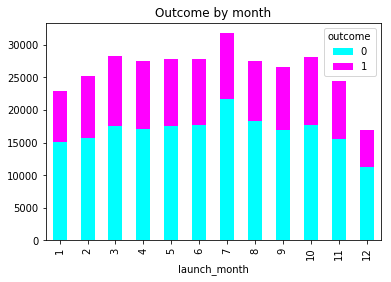

In [60]:
# Launch month: find average outcome: success/failure
launch_pivot = pd.pivot_table(ks_proj2016, index='launch_month',values='outcome', aggfunc=np.mean)
launch_outcome = pd.crosstab(ks_proj2016.launch_month, ks_proj2016.outcome)
launch_outcome['success_perc'] = launch_pivot.outcome
launch_outcome[launch_outcome.columns[0:2]].plot(kind='bar', 
            stacked=True, color=['cyan', 'magenta'], grid=False, title='Outcome by month')
launch_outcome

pandas.core.frame.DataFrame

Text(0.5, 1.0, 'Average Pledge/Backer by Launch Month')

,launch_month,avg_pledge
0,1,57.80
1,2,63.13
2,3,65.55
3,4,64.22
4,5,66.79
5,6,63.19
6,7,51.71
7,8,53.86
8,9,59.34
9,10,59.51


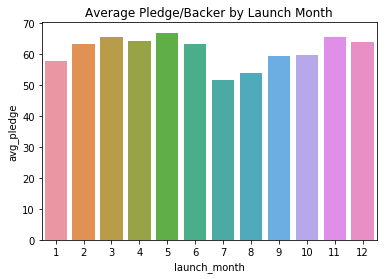

In [59]:
# launch month: see average pledge 
launch_pivot_ap = pd.pivot_table(ks_proj2016, index='launch_month',values='avg_pledge', aggfunc=np.mean).reset_index()
type(launch_pivot_ap)
sns.barplot(x='launch_month', y = 'avg_pledge', 
            data=launch_pivot_ap).set_title("Average Pledge/Backer by Launch Month")
launch_pivot_ap